In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime as dt
import warnings
import shap
import pickle
plt.style.use('dark_background')
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import os


# scikit-learn modules for feature selection and model evaluation
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve,auc,classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

from tabulate import tabulate
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Load the dataset
df = pd.read_csv('../Credit risk/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22.00,59000.00,RENT,123.00,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21.00,9600.00,OWN,5.00,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25.00,9600.00,MORTGAGE,1.00,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23.00,65500.00,RENT,4.00,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24.00,54400.00,RENT,8.00,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
# check the shape of the dataset:
df.shape

(32581, 12)

In [4]:
#get some basic statistical information about the dataset:
#50% is median
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32572.00,32552.00,31686.00,32581.00,29465.00,32581.00,32581.00,32581.00
mean,27.74,66076.03,4.79,9589.37,11.01,0.22,0.17,5.80
std,6.35,62004.58,4.14,6322.09,3.24,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38500.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79200.00,7.00,12200.00,13.47,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


In [5]:
# A Quick Information about the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32572 non-null  float64
 1   person_income               32552 non-null  float64
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 3.0+ MB


In [6]:
df.isnull().sum()

person_age                       9
person_income                   29
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Visualisation

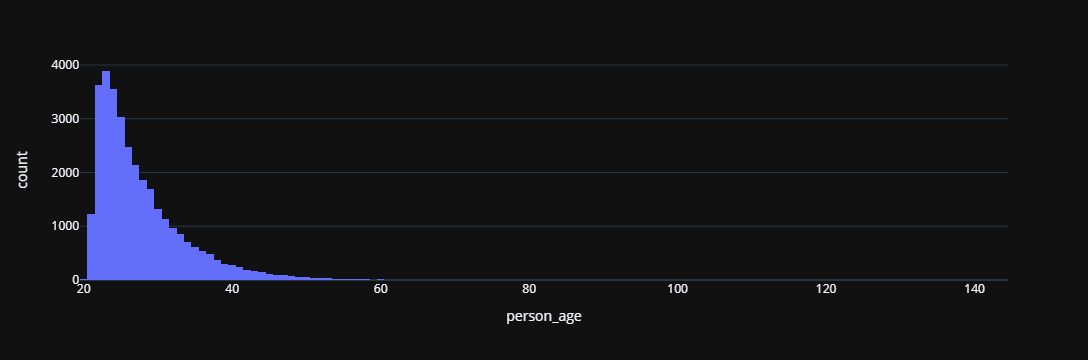

In [7]:
px.histogram(df,x=df['person_age'],template='plotly_dark')

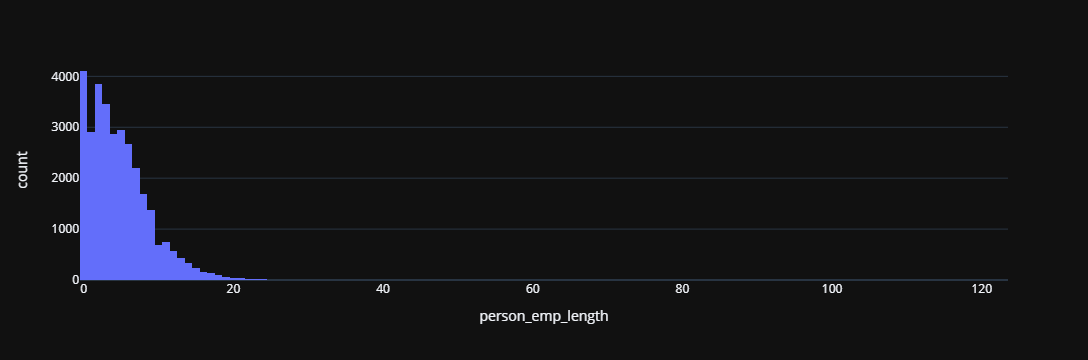

In [8]:
px.histogram(df,x=df['person_emp_length'],template='plotly_dark')

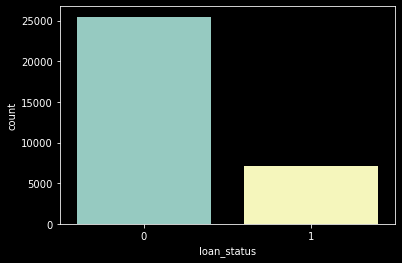

In [9]:
sns.countplot(x=df['loan_status'],data=df);

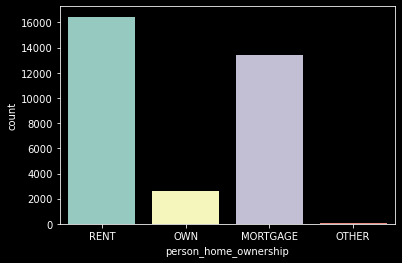

In [10]:
sns.countplot(x=df['person_home_ownership'],data=df);

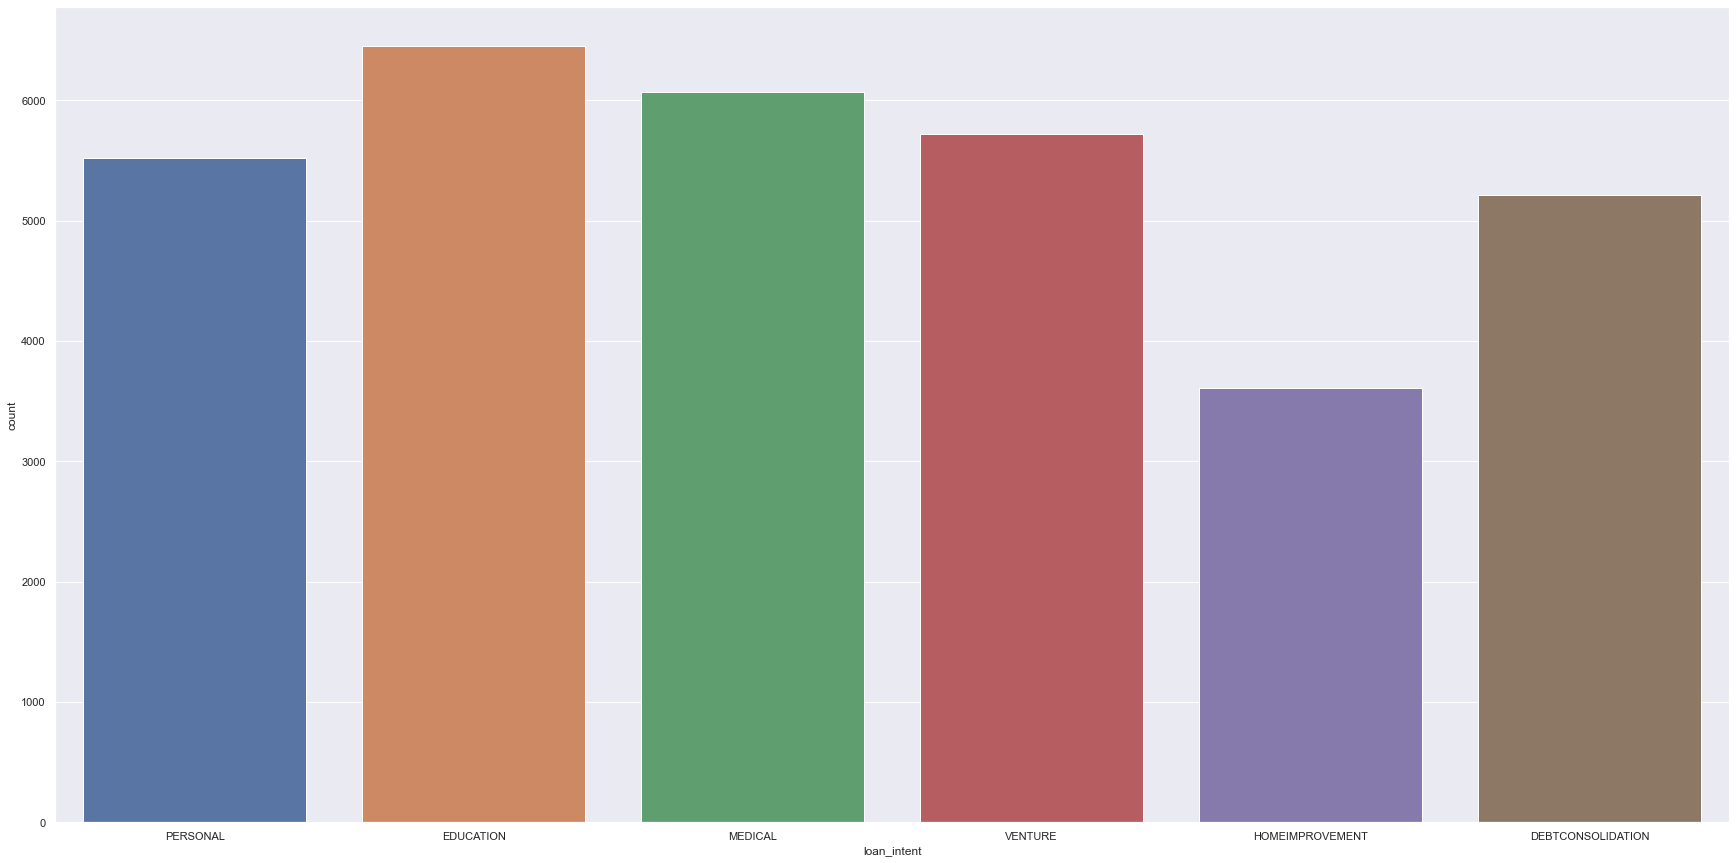

In [11]:
sns.set(rc={'figure.figsize':(30,15)})
sns.countplot(x=df['loan_intent'],data=df);

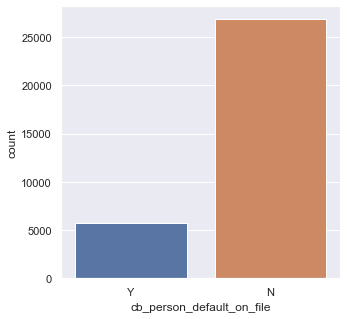

In [12]:
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x=df['cb_person_default_on_file'],data=df);

In [13]:
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

label_mappings = {}

# Iteration 
for column in columns_to_encode:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    df[column] = encoder.transform(df[column])
    label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    label_mappings[column] = label_mapping

# Print the label mappings
for column, mapping in label_mappings.items():
    print(f"Label Mapping for {column}:")
    print(mapping)

Label Mapping for person_home_ownership:
{'MORTGAGE': 0, 'OTHER': 1, 'OWN': 2, 'RENT': 3}
Label Mapping for loan_intent:
{'DEBTCONSOLIDATION': 0, 'EDUCATION': 1, 'HOMEIMPROVEMENT': 2, 'MEDICAL': 3, 'PERSONAL': 4, 'VENTURE': 5}
Label Mapping for loan_grade:
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
Label Mapping for cb_person_default_on_file:
{'N': 0, 'Y': 1}


In [14]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22.00,59000.00,3,123.00,4,3,35000,16.02,1,0.59,1,3
1,21.00,9600.00,2,5.00,1,1,1000,11.14,0,0.10,0,2
2,25.00,9600.00,0,1.00,3,2,5500,12.87,1,0.57,0,3
3,23.00,65500.00,3,4.00,3,2,35000,15.23,1,0.53,0,2
4,24.00,54400.00,3,8.00,3,2,35000,14.27,1,0.55,1,4


In [15]:
#create df without na to make test regressiorn
nonadf = df.dropna()

Intercept: 0.034324607339492275
                            Coefficient
loan_percent_income                1.73
loan_grade                         0.17
person_home_ownership              0.03
cb_person_cred_hist_length         0.00
person_income                      0.00
loan_amnt                         -0.00
person_emp_length                 -0.00
person_age                        -0.00
loan_intent                       -0.02
loan_int_rate                     -0.02
cb_person_default_on_file         -0.02


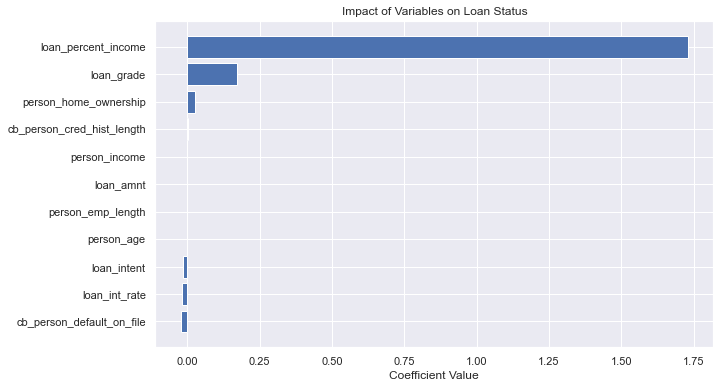

In [16]:
#make simple linear regression to explore dependency of each feature

# Create a LinearRegression model
model = LinearRegression()

# Define features and target variable
X = nonadf.drop(['loan_status'], axis=1)
y = nonadf['loan_status']

model.fit(X, y)

# Print the coefficients intercept and coefficients 
print("Intercept:", model.intercept_)
#print("Coefficients:", model.coef_)

coefficients = dict(zip(X.columns, model.coef_))

# Print the coefficients
#for variable, coefficient in coefficients.items():
#    print(f"{variable}: {coefficient}")
    

# Create a DataFrame and order by coefficients in descending order
coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print the DataFrame
print(coefficients_df)

# Calculate the absolute values of the coefficients
abs_coefficients = abs(model.coef_)

plt.figure(figsize=(10, 6))
plt.barh(coefficients_df.index, coefficients_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Impact of Variables on Loan Status')
plt.gca().invert_yaxis()  # highest impact at the top
plt.show()

In [17]:
# person_age,person_emp_length and person_income has low impact so we can change them with median. loan_int_rate has enought impact to mess up in ml  by changing it with mean or median

In [18]:
X = nonadf.drop(['loan_status', 'loan_int_rate'], axis=1)
y = nonadf['loan_int_rate']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Step 4: Evaluate the regression
y_pred = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.9769942590251356


In [19]:
#fill null data for person_age, person_income, person_emp_length
full_df = df.copy()
median_age = full_df['person_age'].median()
median_income = full_df['person_income'].median()
median_length = full_df['person_emp_length'].median()

# person_age person_income with medians
full_df['person_age'].fillna(median_age, inplace=True)
full_df['person_income'].fillna(median_income, inplace=True)
full_df['person_emp_length'].fillna(median_length, inplace=True)

df.dropna(inplace=True)

In [20]:
# Fill missing values in full_df with regression predictions
missing_rows = full_df[full_df['loan_int_rate'].isnull()]
missing_X = missing_rows.drop(['loan_status', 'loan_int_rate'], axis=1)
missing_predictions = rf_regressor.predict(missing_X)
missing_rows['loan_int_rate'] = missing_predictions
full_df.update(missing_rows)

### feature engineering

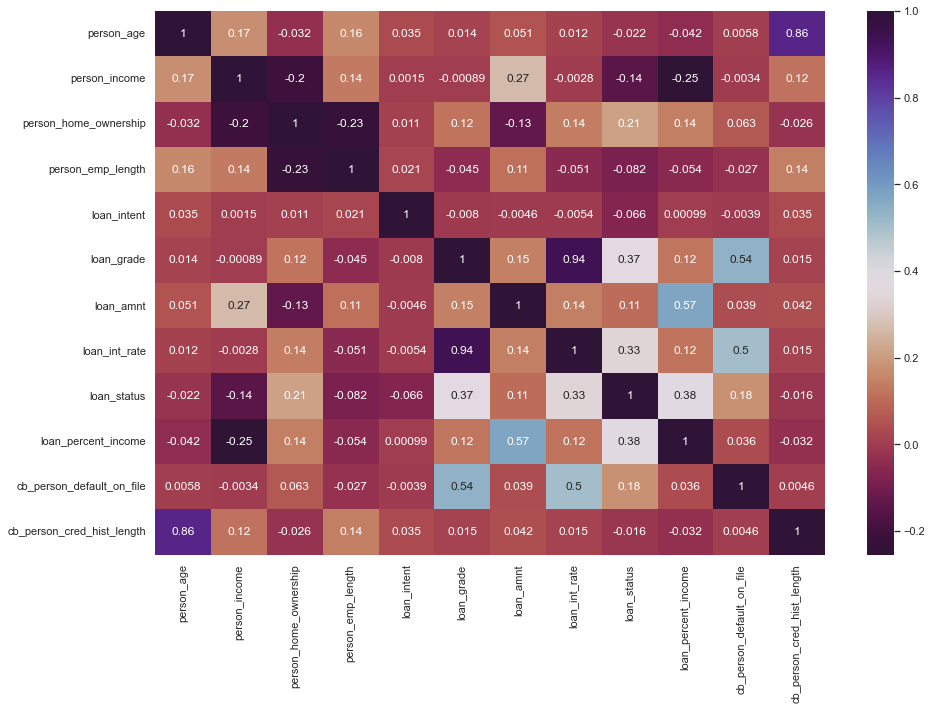

In [21]:
#full correlationm
plt.figure(figsize=(15,10))
sns.heatmap(full_df.corr(),annot=True,cmap='twilight_shifted_r') #afmhot, inferno, icefire
plt.show()

In [22]:
# I wanted to delete low correlation features but we don't have enough features

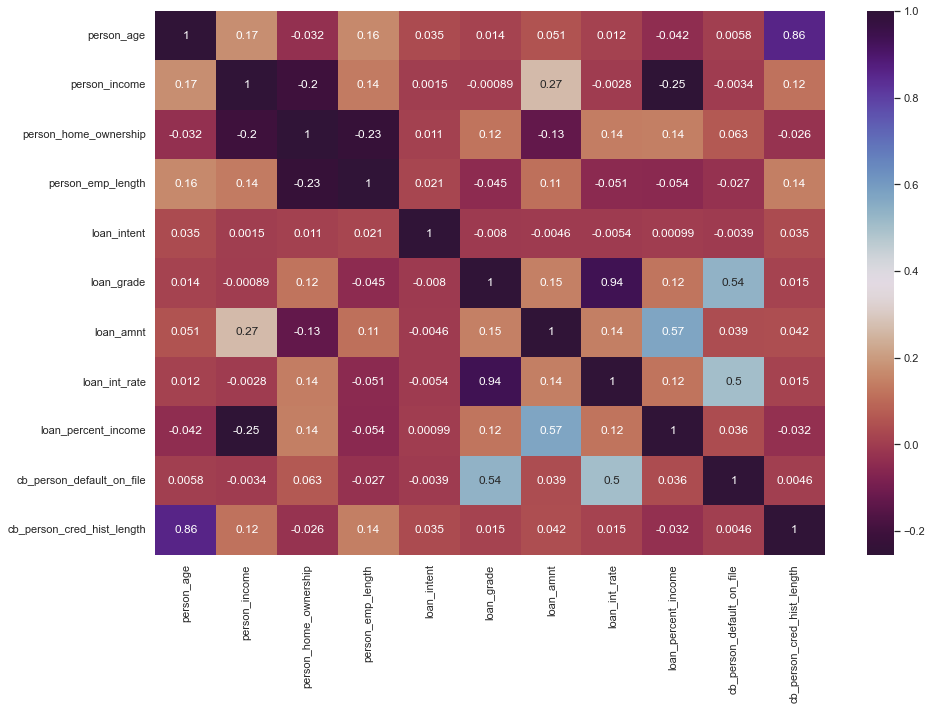

In [23]:
#droping loan_status to explore multicollinearity correlationm
plt.figure(figsize=(15,10))
sns.heatmap(full_df.drop(['loan_status'],axis=1).corr(),annot=True,cmap='twilight_shifted_r')
plt.show()

#### To avoid multicolenearity I will drop person_age, because cb_person_cred_hist_length an person_age has 86% correlation and cb_person_cred_hist_length has higher coefficient in regrresion

In [24]:
full_df.drop('person_age', axis=1, inplace=True)

In [25]:
# Tree based model will fit this type of task so it would be better to do scaling with person_income and loan_amnt
scaler = StandardScaler()
full_df['person_income'] = scaler.fit_transform(full_df['person_income'].values.reshape(-1, 1))
full_df['loan_amnt'] = scaler.fit_transform(full_df['loan_amnt'].values.reshape(-1, 1))

In [26]:
# I will do further feature engineering after ml modeling with Feature Importance 

In [27]:
# AutoML

In [28]:
X = full_df.drop(['loan_status'], axis=1)
y = full_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# in this case we have small data so we can do AutoML and find best model

# Initialize and fit the LazyRegressor model
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print models
print(tabulate (models, headers = 'keys', tablefmt='psql'))

100%|██████████| 29/29 [00:53<00:00,  1.86s/it]

+-------------------------------+------------+---------------------+-----------+------------+--------------+
| Model                         |   Accuracy |   Balanced Accuracy |   ROC AUC |   F1 Score |   Time Taken |
|-------------------------------+------------+---------------------+-----------+------------+--------------|
| XGBClassifier                 |   0.933251 |            0.86309  |  0.86309  |   0.930059 |    1.81156   |
| LGBMClassifier                |   0.931257 |            0.854385 |  0.854385 |   0.927395 |    0.404875  |
| RandomForestClassifier        |   0.930029 |            0.852112 |  0.852112 |   0.926047 |    3.98452   |
| BaggingClassifier             |   0.926807 |            0.850784 |  0.850784 |   0.922998 |    0.854844  |
| ExtraTreesClassifier          |   0.923124 |            0.844459 |  0.844459 |   0.919013 |    2.51952   |
| DecisionTreeClassifier        |   0.883075 |            0.839267 |  0.839267 |   0.884051 |    0.158348  |
| AdaBoostClassifie

In [30]:
# Best model is XGBoost classifier

In [31]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)



xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')
xgb_classifier.fit(X_train, y_train)


y_test_pred = xgb_classifier.predict(X_test)


test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy:", test_accuracy)

report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Set):\n", report)

# Step 4: Make predictions on the validation set (optional).
y_val_pred = xgb_classifier.predict(X_val)

# Calculate accuracy and print the classification report for the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Set Accuracy:", val_accuracy)

report_val = classification_report(y_val, y_val_pred)
print("Classification Report (Validation Set):\n", report_val)

Test Set Accuracy: 0.935134029056681
Classification Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3821
         1.0       0.95      0.74      0.83      1066

    accuracy                           0.94      4887
   macro avg       0.94      0.86      0.90      4887
weighted avg       0.94      0.94      0.93      4887

Validation Set Accuracy: 0.9349427168576104
Classification Report (Validation Set):
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3821
         1.0       0.94      0.75      0.83      1067

    accuracy                           0.93      4888
   macro avg       0.94      0.87      0.90      4888
weighted avg       0.94      0.93      0.93      4888



In [32]:
# now we will do oversampling
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

xgb_classifier2 = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_classifier2.fit(X_train_resampled, y_train_resampled)

y_test_pred2 = xgb_classifier2.predict(X_test)

# Calculate accuracy and print the classification report
test_accuracy2 = accuracy_score(y_test, y_test_pred2)
print("Test Set Accuracy:", test_accuracy2)

report2 = classification_report(y_test, y_test_pred2)
print("Classification Report (Test Set):\n", report2)

# Optionally, make predictions on the validation set and evaluate it as well
y_val_pred2 = xgb_classifier.predict(X_val)
val_accuracy2 = accuracy_score(y_val, y_val_pred)

print("Validation Set Accuracy:", val_accuracy2)
report_val2 = classification_report(y_val, y_val_pred2)
print("Classification Report (Validation Set):\n", report_val2)

Test Set Accuracy: 0.9218334356455904
Classification Report (Test Set):
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      3821
         1.0       0.84      0.80      0.82      1066

    accuracy                           0.92      4887
   macro avg       0.89      0.88      0.88      4887
weighted avg       0.92      0.92      0.92      4887

Validation Set Accuracy: 0.9349427168576104
Classification Report (Validation Set):
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3821
         1.0       0.94      0.75      0.83      1067

    accuracy                           0.93      4888
   macro avg       0.94      0.87      0.90      4888
weighted avg       0.94      0.93      0.93      4888



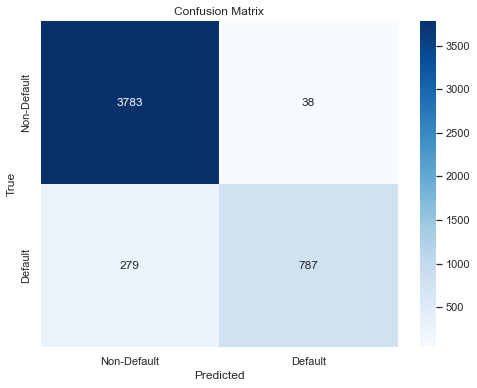

In [33]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

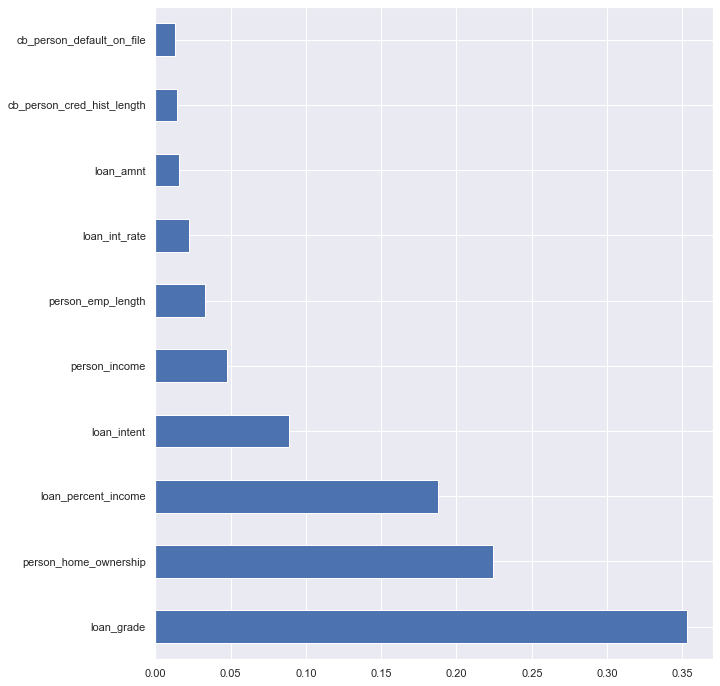

In [34]:
plt.figure(figsize=(10, 12))
feat_importances = pd.Series(xgb_classifier.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh')
plt.show()

In [35]:
# With this chart we can assume that cb_person_default_on_file is less important in our model so we can drop it and see the change in results

In [36]:
# Create and train the XGBoost classifier without cb_person_default_on_file
xgb_classifier2 = xgb.XGBClassifier()
xgb_classifier2.fit(X_train.drop('cb_person_default_on_file', axis=1), y_train)

y_pred = xgb_classifier2.predict(X_test.drop('cb_person_default_on_file',axis=1))

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Print evaluation results
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.9345201555146306
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3821
         1.0       0.96      0.73      0.83      1066

    accuracy                           0.93      4887
   macro avg       0.94      0.86      0.89      4887
weighted avg       0.94      0.93      0.93      4887



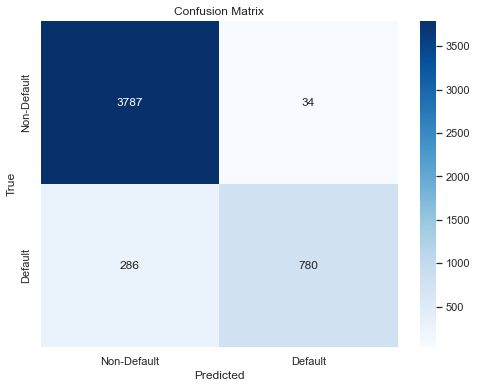

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# This 2 models has a really low difference in results 

In [39]:
# Hyperparameter tuning

In [40]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    #'min_child_weight': [1, 2, 3],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Train the final model with the best parameters
final_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
final_model.fit(X_train, y_train)

# Make predictions on the test set
y_best_pred = final_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_best_pred)
roc_auc = roc_auc_score(y_test, y_best_pred)
precision = precision_score(y_test, y_best_pred)
recall = recall_score(y_test, y_best_pred)
f1_sc = f1_score(y_test, y_best_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'roc_auc: {roc_auc:.4f}')
print(f'precision: {precision:.4f}')
print(f'recall: {recall:.4f}')
print(f'f1_score: {f1_sc:.4f}')


# View classification report for more detailed metrics
print(classification_report(y_test, y_best_pred))

Accuracy: 0.9351
roc_auc: 0.8584
precision: 0.9735
recall: 0.7223
f1_score: 0.8293
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      3821
         1.0       0.97      0.72      0.83      1066

    accuracy                           0.94      4887
   macro avg       0.95      0.86      0.89      4887
weighted avg       0.94      0.94      0.93      4887



In [41]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9336139338141329
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


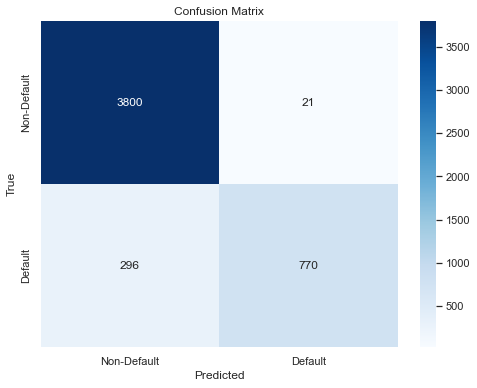

In [42]:
conf_matrix = confusion_matrix(y_test, y_best_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

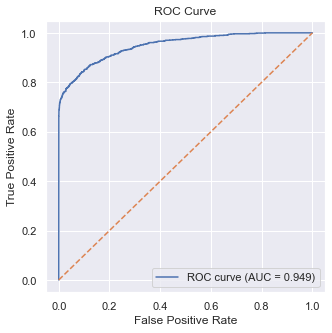

In [43]:
probas = final_model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
rocauc_score = roc_auc_score(y_test, probas)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probas)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {rocauc_score:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

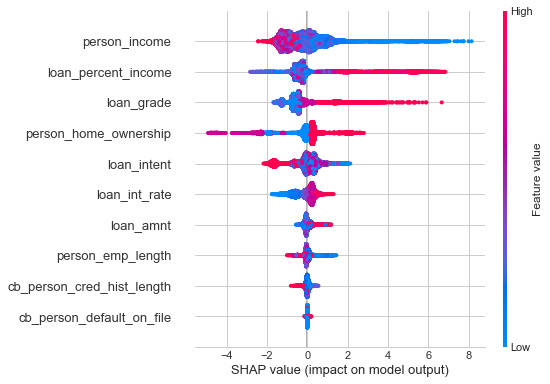

In [44]:
# Create summary plot with shap
explainer = shap.TreeExplainer(final_model)

shap_values = explainer(X_train)
feature_importance = np.abs(shap_values.values).mean(0)
feature_names = full_df.drop(['loan_status'], axis=1).columns

plt.style.use('seaborn-whitegrid')
shap.summary_plot(shap_values, feature_names=feature_names)

In [45]:
# Save the model to a pickle file
with open("model.pkl", "wb") as f:
    pickle.dump(final_model, f)

In [46]:
final_model.save_model("model.json")